In [31]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

#use gpu number 3 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

file_id=6448
#file_id=23114

base_path="/home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/"
file_dry=os.path.join(base_path, "dry",str(file_id),"vocals.wav")
file_wet=os.path.join(base_path, "wet",str(file_id),"vocals.wav")

file_dry_fxnorm=os.path.join(base_path,"dry", str(file_id), "vocals_normalized.wav")
file_wet_fxnorm=os.path.join(base_path, "wet",str(file_id), "vocals_normalized.wav")

file_dry_fxnorm_dr=os.path.join(base_path, "dry", str(file_id), "vocals_normalized_dr.wav")
file_wet_fxnorm_dr=os.path.join(base_path, "wet",str(file_id),"vocals_normalized_dr.wav")

import soundfile as sf

print("Loading files:", file_dry, file_wet)
dry, sr = sf.read(file_dry)
print("Loading files:", file_dry, file_wet)
wet, sr = sf.read(file_wet)
print("files loaded")

#file_dry_fxnorm, sr=sf.read(file_dry_fxnorm_dr)
#file_wet_fxnorm, sr=sf.read(file_wet_fxnorm_dr)

dry=torch.from_numpy(dry.T).float().unsqueeze(0)
wet=torch.from_numpy(wet.T).float().unsqueeze(0)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)

dry=dry.mean(dim=1, keepdim=True)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)


start_t=15*sr
segment_length = 524288
wet_segment = wet[...,start_t:start_t + segment_length].to(device)


import pyloudnorm as pyln
meter = pyln.Meter(sr)
normaliser = lambda x: pyln.normalize.loudness(
    x, meter.integrated_loudness(x), -18.0
)

print("dry", dry.shape, dry.min(), dry.max())


#dry = torch.from_numpy(normaliser(dry.numpy().T).T).float().to(device)
#wet = torch.from_numpy(normaliser(wet.numpy().T).T).float().to(device)
#dry_fxnorm = torch.from_numpy(normaliser(dry_fxnorm.numpy().T).T).float().to(device)


print("dry", dry.shape,dry.min(), dry.max())
dry_segment = dry[...,start_t:start_t + segment_length].to(device)


from IPython.display import Audio

Audio(dry_segment[0].cpu().numpy(), rate=sr, normalize=False)
#Audio(wet_segment[0].cpu().numpy(), rate=sr, normalize=True)

#RMS normalization of the dry segment and the wet segment

RMS_norm=-25
def rms_normalize(x, target_rms):
    x_RMS=20*torch.log10(torch.sqrt(torch.mean(x**2, dim=(-1), keepdim=True).mean(dim=-2, keepdim=True)))
    gain=target_rms - x_RMS
    gain=10**(gain/20)
    x= x * gain
    return x
dry_segment = rms_normalize(dry_segment, RMS_norm)
wet_segment = wet_segment.mean(dim=1, keepdim=True)
wet_segment = rms_normalize(wet_segment, RMS_norm)



Using device: cuda
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/6448/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/6448/vocals.wav
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/6448/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/6448/vocals.wav
files loaded
dry torch.Size([1, 1, 11065479]) tensor(-0.1188) tensor(0.1767)
dry torch.Size([1, 1, 11065479]) tensor(-0.1188) tensor(0.1767)


(array([2.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 5.0000e+00,
        2.0000e+00, 8.0000e+00, 1.5000e+01, 1.6000e+01, 2.5000e+01,
        2.2000e+01, 5.8000e+01, 7.8000e+01, 1.0400e+02, 1.3400e+02,
        1.4100e+02, 1.8400e+02, 2.1700e+02, 3.1100e+02, 4.1600e+02,
        5.0200e+02, 6.3500e+02, 7.3200e+02, 7.9700e+02, 9.1300e+02,
        9.8300e+02, 1.1660e+03, 1.2060e+03, 1.4770e+03, 1.6520e+03,
        1.8580e+03, 2.2320e+03, 2.5110e+03, 3.0590e+03, 3.5430e+03,
        4.1700e+03, 4.6600e+03, 5.5040e+03, 6.5000e+03, 7.6160e+03,
        8.7430e+03, 9.8870e+03, 1.1744e+04, 1.3393e+04, 1.5277e+04,
        1.6341e+04, 1.7780e+04, 2.0823e+04, 2.8576e+04, 8.2171e+04,
        7.8732e+04, 2.7272e+04, 1.7441e+04, 1.3594e+04, 1.1570e+04,
        1.0150e+04, 9.2540e+03, 8.3080e+03, 7.3580e+03, 6.6270e+03,
        6.0370e+03, 5.5070e+03, 4.6880e+03, 4.1740e+03, 3.7550e+03,
        3.2370e+03, 2.9120e+03, 2.6200e+03, 2.3240e+03, 2.1390e+03,
        1.8350e+03, 1.7280e+03, 1.4710e+03, 1.29

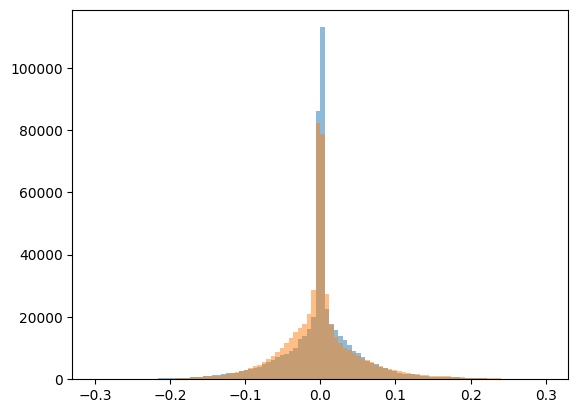

In [32]:
#plot histogram of dry_segment
import matplotlib.pyplot as plt
plt.hist(dry_segment[0,0].cpu().numpy().flatten(), bins=100, range=(-0.3, 0.3), alpha=0.5, label='Dry Segment')
plt.hist(wet_segment[0,0].cpu().numpy().flatten(), bins=100, range=(-0.3, 0.3), alpha=0.5, label='Wet Segment')


In [33]:
def analyze_dynamics(audio, frame_size=2048, hop_size=512):
    """Extract dynamic characteristics of audio signal"""
    
    # Calculate RMS energy in frames
    B, C, T = audio.shape
    audio = audio.view(B * C, T)  # Reshape to (B*C, 1, T) for unfolding
    frames = audio.unfold(1, frame_size, hop_size)
    rms = torch.sqrt(torch.mean(frames**2, dim=2))
    
    # Convert to dB
    rms_db = 20 * torch.log10(rms + 1e-8)
    
    # Calculate distribution statistics
    mean_db = torch.mean(rms_db, dim=1)
    std_db = torch.std(rms_db, dim=1)
    
    # Calculate percentiles for more detailed distribution matching
    percentiles = torch.tensor([10, 25, 50, 75, 90], device=audio.device)
    perc_values = torch.quantile(rms_db, percentiles/100, dim=1)
    
    return {
        'mean_db': mean_db,
        'std_db': std_db,
        'percentiles': perc_values,
    }
out= analyze_dynamics(dry_segment)
print(out)
out= analyze_dynamics(wet_segment.mean(dim=1, keepdim=True))
print(out)

{'mean_db': tensor([-38.2326], device='cuda:0'), 'std_db': tensor([20.1427], device='cuda:0'), 'percentiles': tensor([[-74.3985],
        [-50.8441],
        [-29.2511],
        [-24.4565],
        [-20.4077]], device='cuda:0')}
{'mean_db': tensor([-34.0533], device='cuda:0'), 'std_db': tensor([16.5566], device='cuda:0'), 'percentiles': tensor([[-52.1370],
        [-41.2215],
        [-27.4136],
        [-23.8376],
        [-20.2306]], device='cuda:0')}


In [ ]:

from fx_model.processors.diffvox_functional import  avg_rms, compexp_gain
def apply_comp(dry_audio, wet_audio):
    """Match dynamics using compressor-expander approach"""
    
    # Analyze dynamic range statistics
    dry_stats = analyze_dynamics(dry_audio)
    wet_stats = analyze_dynamics(wet_audio)
    
    # Calculate compressor/expander parameters based on distribution differences
    comp_thresh = wet_stats['percentiles'][3]  # 75th percentile
    exp_thresh = wet_stats['percentiles'][1]   # 25th percentile
    
    # Calculate ratios based on standard deviation differences
    if dry_stats['std_db'] > wet_stats['std_db']:
        # Need more compression
        comp_ratio = dry_stats['std_db'] / wet_stats['std_db']
        exp_ratio = torch.tensor(1.0, device=dry_audio.device)  # Gentle expansion
    else:
        # Need more expansion
        #comp_ratio = 1.2  # Gentle compression
        comp_ratio = torch.tensor(1.0, device=dry_audio.device)
        exp_ratio = wet_stats['std_db'] / dry_stats['std_db']
    
    print(f"Compressor Threshold: {comp_thresh.item():.2f} dB, Ratio: {comp_ratio.item():.2f}")
    print(f"Expander Threshold: {exp_thresh.item():.2f} dB, Ratio: {exp_ratio.item():.2f}")
    # Extract RMS envelope
    dry_audio= dry_audio.reshape(-1, dry_audio.shape[-1])  # Flatten batch and channel dimensions
    dry_rms = avg_rms(dry_audio, avg_coef=torch.tensor(0.9, device=dry_audio.device))
    
    # Apply compexp gain
    gain = compexp_gain(
        dry_rms,
        comp_thresh=comp_thresh,
        comp_ratio=comp_ratio,
        exp_thresh=exp_thresh,
        exp_ratio=exp_ratio,
        at=0.01,  # Fast attack
        rt=0.1    # Moderate release
    )
    
    # Apply gain
    matched_audio = dry_audio * gain
    
    return matched_audio

dry_segment_matched = dynamic_match_compexp(dry_segment, wet_segment)
wet_segment_matched = dynamic_match_compexp(wet_segment, dry_segment)

Compressor Threshold: -23.84 dB, Ratio: 1.22
Expander Threshold: -41.22 dB, Ratio: 0.80
Compressor Threshold: -24.46 dB, Ratio: 0.80
Expander Threshold: -50.84 dB, Ratio: 1.22


AssertionError: 

(array([2.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 5.0000e+00,
        2.0000e+00, 8.0000e+00, 1.5000e+01, 1.6000e+01, 2.5000e+01,
        2.2000e+01, 5.8000e+01, 7.8000e+01, 1.0400e+02, 1.3400e+02,
        1.4100e+02, 1.8400e+02, 2.1700e+02, 3.1100e+02, 4.1600e+02,
        5.0200e+02, 6.3500e+02, 7.3200e+02, 7.9700e+02, 9.1300e+02,
        9.8300e+02, 1.1660e+03, 1.2060e+03, 1.4770e+03, 1.6520e+03,
        1.8580e+03, 2.2320e+03, 2.5110e+03, 3.0590e+03, 3.5430e+03,
        4.1700e+03, 4.6600e+03, 5.5040e+03, 6.5000e+03, 7.6160e+03,
        8.7430e+03, 9.8870e+03, 1.1744e+04, 1.3393e+04, 1.5277e+04,
        1.6341e+04, 1.7780e+04, 2.0823e+04, 2.8576e+04, 8.2171e+04,
        7.8732e+04, 2.7272e+04, 1.7441e+04, 1.3594e+04, 1.1570e+04,
        1.0150e+04, 9.2540e+03, 8.3080e+03, 7.3580e+03, 6.6270e+03,
        6.0370e+03, 5.5070e+03, 4.6880e+03, 4.1740e+03, 3.7550e+03,
        3.2370e+03, 2.9120e+03, 2.6200e+03, 2.3240e+03, 2.1390e+03,
        1.8350e+03, 1.7280e+03, 1.4710e+03, 1.29

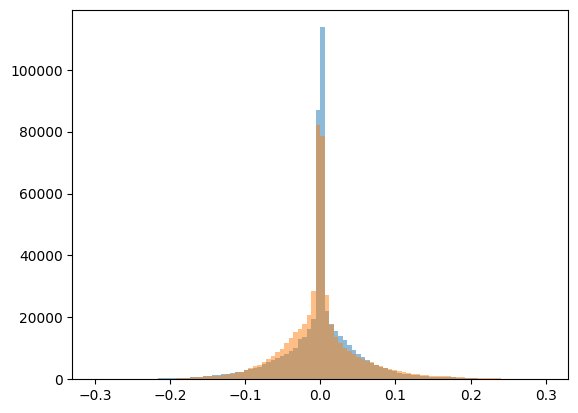

In [35]:
#plot histogram of dry_segment
import matplotlib.pyplot as plt
plt.hist(dry_segment_matched[0].cpu().numpy().flatten(), bins=100, range=(-0.3, 0.3), alpha=0.5, label='Dry Segment')
plt.hist(wet_segment[0,0].cpu().numpy().flatten(), bins=100, range=(-0.3, 0.3), alpha=0.5, label='Wet Segment')